# Ch.12 Stochastics

In [1]:
import math
import numpy as np  
from pylab import plt, mpl
import warnings
warnings.filterwarnings('ignore')
print('Matplotlib version: {}'.format(mpl.__version__))
print('NumPy version: {}'.format(np.__version__))

Matplotlib version: 3.8.4
NumPy version: 1.26.4


## Random numbers
We may need (pseudo) random numbers to simulate random processes. NumPy provides methods to sample random numbers from several distributions: uniform, Gaussian or normal, Poisson, Chi square, and so forth. For example, we can sample 10 random numbers from the uniform distribution in the interval [0, 1) using the random() method of the generator instance. Several algorithms can be used to sample a distribution. The starting point is to sample from the uniform distribution for example using modula arithmetic. Once we have a sample of the uniform distribution we can create a sample from any other distribution.

In [4]:
np.random.seed(100)
rng = np.random.default_rng()
sample_size = 10
rng.random(sample_size)

array([0.56454448, 0.72562593, 0.51051293, 0.70148698, 0.57213495,
       0.43077649, 0.25502408, 0.17974464, 0.44468461, 0.538256  ])

In [3]:
sample_size = 500
rn1 = rng.standard_normal(sample_size)  
rn2 = rng.normal(100, 20, sample_size)  
rn3 = rng.lognormal(mean=1.0, sigma=0.25, size=sample_size)  
rn4 = rng.poisson(lam=1.0, size=sample_size)  

Text(0.5, 1.0, 'Poisson')

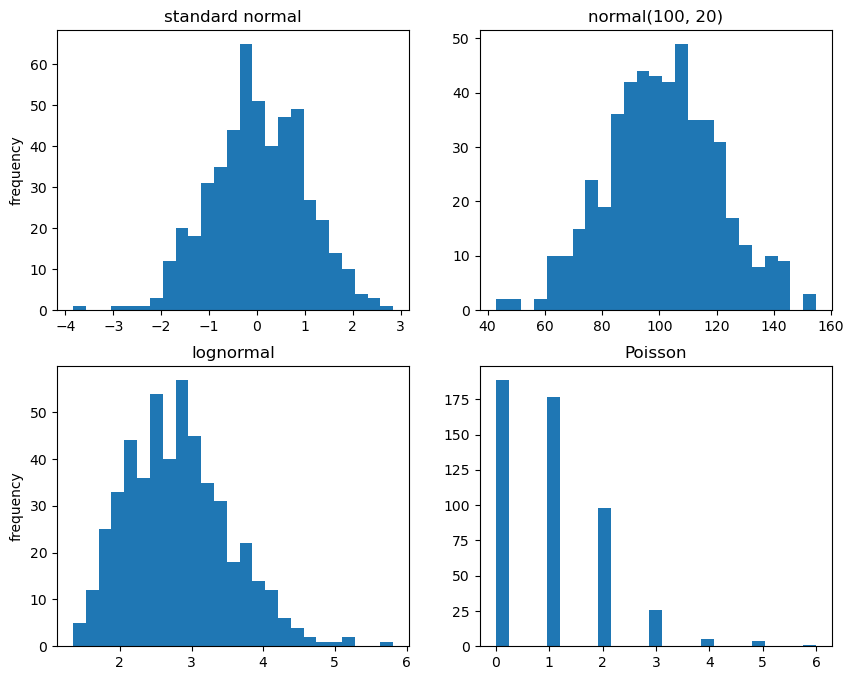

In [4]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
ax1.hist(rn1, bins=25)
ax1.set_title('standard normal')
ax1.set_ylabel('frequency')
ax2.hist(rn2, bins=25)
ax2.set_title('normal(100, 20)')
ax3.hist(rn3, bins=25)
ax3.set_title('lognormal')
ax3.set_ylabel('frequency')
ax4.hist(rn4, bins=25)
ax4.set_title('Poisson')

## Simulations
We can use a sample taken from a distribution to simulate a process. For example we can sample from a normal distribution to simulate the future index level according to the Black-Scholes-Merton (BSM) equation

$$S_T = S_0 \exp((r - \frac{1}{2}\sigma^2)T + \sigma \sqrt{T}z)$$

and we can build a distribution of the values returned from it. In the equation $S_0$ is the initial index level, r the riskless return rate, $\sigma$ the volatility, T the time horizon in years, and z a sample from the normal distribution. 

In [5]:
S0 = 100  
r = 0.05  
sigma = 0.25  
T = 2.0  
I = 10000  # number of samples to be returned from the normal dist.
z = rng.standard_normal(I)
ST1 = S0 * np.exp((r - 0.5 * sigma ** 2) * T + sigma * math.sqrt(T) * z) 
ST1.shape

(10000,)

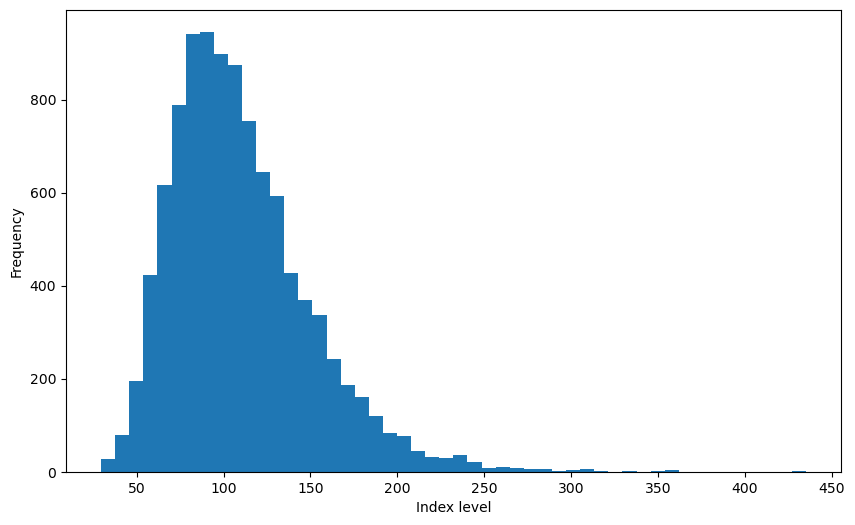

In [6]:
plt.figure(figsize=(10, 6))
plt.hist(ST1, bins=50)
plt.xlabel('Index level')
plt.ylabel('Frequency');

We can compare the distribution of the index levels from the BSM equation to a lognormal distribution with parameters with the same mean, $\mu = r$, and standard deviation $\sigma$.

In [22]:
ST2 = S0 * rng.lognormal((r - 0.5 * sigma ** 2) * T,
                        sigma * math.sqrt(T), size=I)  

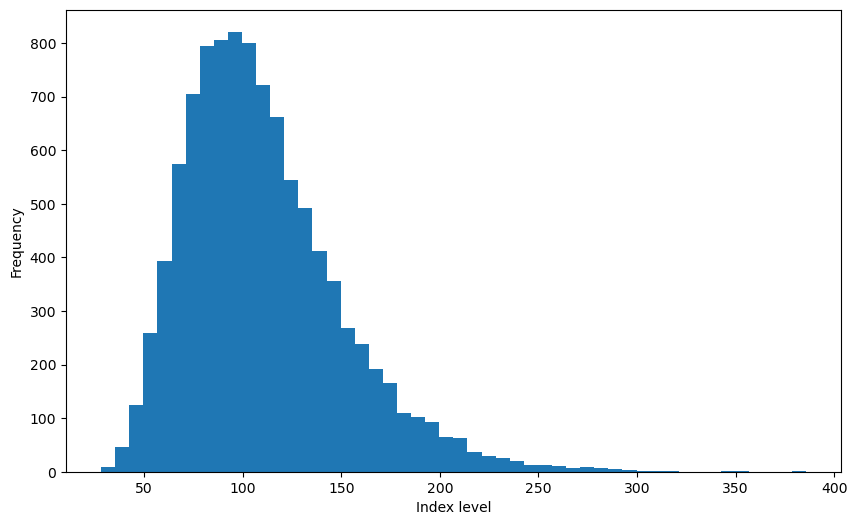

In [23]:
plt.figure(figsize=(10, 6))
plt.hist(ST2, bins=50)
plt.xlabel('Index level')
plt.ylabel('Frequency');

In [24]:
import scipy.stats as scs
def print_statistics(a1, a2):
    ''' Prints selected statistics.
    
    Parameters
    ==========
    a1, a2: ndarray objects
        results objects from simulation
    '''
    sta1 = scs.describe(a1)  
    sta2 = scs.describe(a2)  
    print('%14s %14s %14s' % 
        ('statistic', 'data set 1', 'data set 2'))
    print(45 * "-")
    print('%14s %14.3f %14.3f' % ('size', sta1[0], sta2[0]))
    print('%14s %14.3f %14.3f' % ('min', sta1[1][0], sta2[1][0]))
    print('%14s %14.3f %14.3f' % ('max', sta1[1][1], sta2[1][1]))
    print('%14s %14.3f %14.3f' % ('mean', sta1[2], sta2[2]))
    print('%14s %14.3f %14.3f' % ('std', np.sqrt(sta1[3]), np.sqrt(sta2[3])))
    print('%14s %14.3f %14.3f' % ('skew', sta1[4], sta2[4]))
    print('%14s %14.3f %14.3f' % ('kurtosis', sta1[5], sta2[5]))

In [25]:
print_statistics(ST1, ST2)

     statistic     data set 1     data set 2
---------------------------------------------
          size      10000.000      10000.000
           min         25.211         28.219
           max        398.073        385.525
          mean        110.483        110.279
           std         40.427         39.782
          skew          1.151          1.072
      kurtosis          2.351          1.897


## Stochastic processes
A stochastic process can be represented as a sequence of random variables that can take a value from a probability distribution. We may assume that the stochastic variables are independent from each other or that there is a dependency, a correlation between one variable and one or more of the previous ones. If we assume a variable depends only on the previous one we are assuming that the process is a Markov process. A Markov process is said to be memoryless since it doesn't consider past values beyond the current one to predict the next one. Now we assume the price of a stock to be a Markov process that follows the stochastic differential equation, aka geometric Brownian motion

$$dS = rSdt + \sigma S dz$$

S is the index level, r the riskless return rate, $\sigma$ the volatility, t the time, and z the Brownian distribution. This equation when integrated returns the BSM equation that we saw before. The stochastic differential equation can also be discretized and integrated iteratively.

$$S_t = S_{t - \Delta t} \exp((r - \frac{1}{2}\sigma^2)\Delta t + \sigma \sqrt{\Delta t}z)$$

We take a number of M=50 consecutive samples of size I=10000 of the BSM process. Each time we add the random component sampled from the normal distribution. Every sample contains I stochastic values and at each time step a new value is calculated for each of them, following the BSM equation, based on the previous value and adding the brownian motion component.   

In [27]:
I = 10000 # sample size  
M = 50  
dt = T / M  
S = np.zeros((M + 1, I))  
S[0] = S0  
for t in range(1, M + 1):
    z = rng.standard_normal(I)
    S[t] = S[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * math.sqrt(dt) * z)  
S.shape

(51, 10000)

We plot the histogram of the index levels at the latest time step. If we plot the distribution from the first sample we can see that the shape is Gaussian and then changes to an asymmetric shape after some time steps 

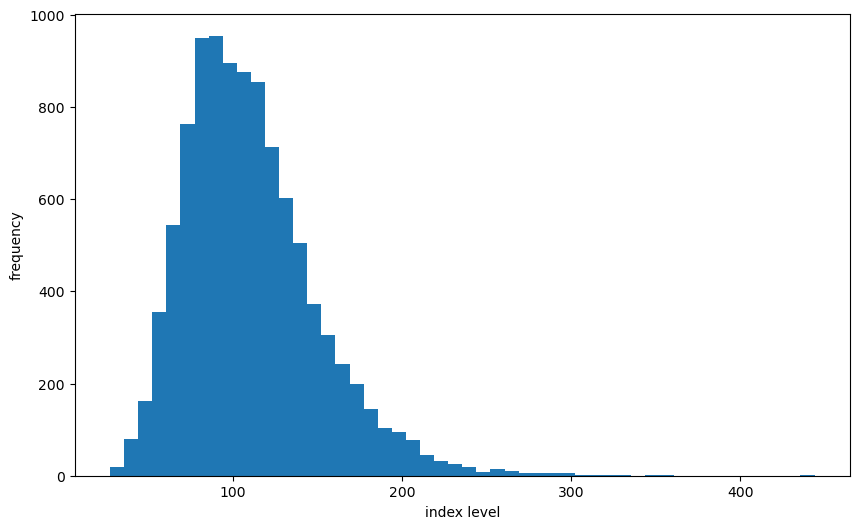

In [28]:
plt.figure(figsize=(10, 6))
plt.hist(S[-1], bins=50)
plt.xlabel('index level')
plt.ylabel('frequency');

At each time step the distribution of the I values will be slightly different. The difference grows with time so that it will become more asymmetric. This can be seen directly from the plot of the I values with time, in M time steps.

to-be-done: add a vertical line to represent the state at, e.g time t=3, 10, 40 

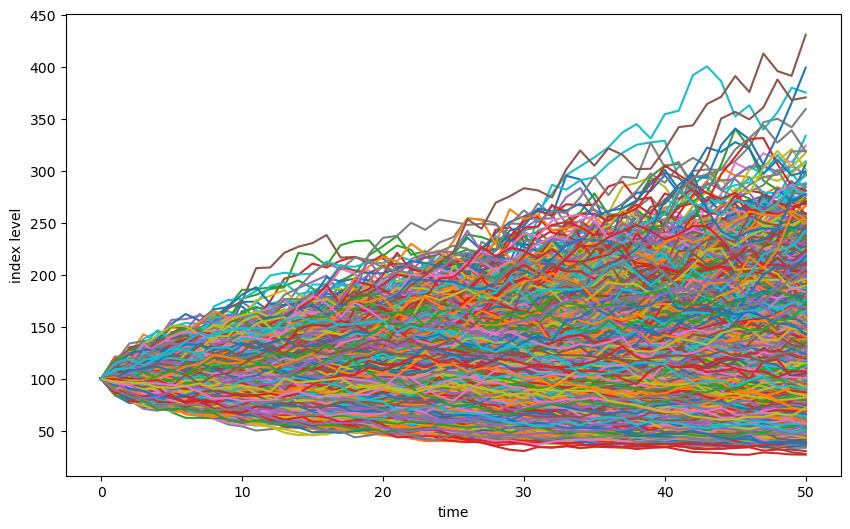

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(S[:, :], lw=1.5)
plt.xlabel('time')
plt.ylabel('index level');

We compare the moments of the two distributions for the BSM equation, one computed from the differential equation and the other previously computed from the static solution. 

In [33]:
print_statistics(S[-1], ST2)

     statistic     data set 1     data set 2
---------------------------------------------
          size      10000.000      10000.000
           min         20.160         28.219
           max        388.453        385.525
          mean        110.949        110.279
           std         40.720         39.782
          skew          1.138          1.072
      kurtosis          2.151          1.897
